Import

In [1]:
import copy
import pandas as pd

from pathlib import Path
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPool1D, Flatten, Dense, Activation
from tensorflow.keras.utils import to_categorical

Load CSV data

In [2]:
df = pd.read_csv(r"data\full_dataset.csv")  # your saved dataset

# Select the feature columns
FEATURE_COLUMNS = [
    "accel_x","accel_y","accel_z",
    "gravity_x","gravity_y","gravity_z",
    "gyro_x","gyro_y","gyro_z",
    "orient_x","orient_y","orient_z","orient_w",
    "mag_x","mag_y","mag_z"
]

# Extract X and y
X_full = df[FEATURE_COLUMNS].values
y_full = df["label"].values

Create Windows

In [3]:
WINDOW_SIZE = 100      # number of samples per window (e.g., 2 seconds at 50 Hz)
WINDOW_STEP = 50       # 50% overlap → smoother predictions

def create_windows(X, y, size, step):
    X_windows = []
    y_windows = []

    for start in range(0, len(X) - size + 1, step):
        end = start + size

        window_X = X[start:end]

        # Pick the most frequent label in the window
        window_y = np.bincount(y[start:end]).argmax()

        X_windows.append(window_X)
        y_windows.append(window_y)

    return np.array(X_windows), np.array(y_windows)

x_windows, y_windows = create_windows(X_full, y_full, WINDOW_SIZE, WINDOW_STEP)


Split data set for windows

In [4]:
# Shuffle the windows
p = np.random.permutation(len(x_windows))
x_windows = x_windows[p]
y_windows = y_windows[p]

# Split the data into training, validation, and test sets
# train (70%) / val (10%) / test (20%)
test_ratio = 0.20
val_ratio  = 0.10   # from the remaining 80%

#Compute split sizes:
n_total = len(x_windows)
n_test = int(n_total * test_ratio)
n_val  = int(n_total * val_ratio)

# Perform the split
# Test set
x_test = x_windows[:n_test]
y_test = y_windows[:n_test]

# Validation set
x_val = x_windows[n_test : n_test + n_val]
y_val = y_windows[n_test : n_test + n_val]

# Training set
x_train = x_windows[n_test + n_val :]
y_train = y_windows[n_test + n_val :]

In [5]:
# Get the number of unique classes
NUM_CLASSES = len(np.unique(y_windows))

# Convert labels to one-hot encoding
y_train_encoded = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_encoded   = to_categorical(y_val, num_classes=NUM_CLASSES)
y_test_encoded  = to_categorical(y_test, num_classes=NUM_CLASSES)

Export data set

In [6]:
# Flatten X data from (Windows, Time Steps, Features) to (Windows, Time Steps * Features)
np.savetxt('x_train_polyhar.csv', x_train.reshape((x_train.shape[0], -1)), delimiter=',', fmt='%s')
np.savetxt('y_train_polyhar.csv', y_train_encoded, delimiter=',', fmt='%s')
np.savetxt('x_test_polyhar.csv', x_test.reshape((x_test.shape[0], -1)), delimiter=',', fmt='%s')
np.savetxt('y_test_polyhar.csv', y_test_encoded, delimiter=',', fmt='%s')
np.savetxt('x_val_polyhar.csv', x_val.reshape((x_val.shape[0], -1)), delimiter=',', fmt='%s')
np.savetxt('y_val_polyhar.csv', y_val_encoded, delimiter=',', fmt='%s')

Build the model

In [13]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPool1D, Flatten, Dense, Activation, Dropout
from tensorflow.keras import regularizers

WINDOW_SIZE = 100
NUM_FEATURES = 16 # Based on your decision to remove mag_cal_x/y/z
NUM_CLASSES = 4 

model = Sequential()
model.add(Input(shape=(WINDOW_SIZE, NUM_FEATURES))) 

# Simplified architecture with max 64 filters
model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=4)) # Reduced pool size for better feature retention

# Add Dropout for regularization (CRITICAL)
model.add(Dropout(0.3)) 

model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=4))

model.add(Flatten())

# Add L2 Regularization to the Dense layer (CRITICAL)
model.add(Dense(
    units=NUM_CLASSES, 
    kernel_regularizer=regularizers.l2(0.001) # Penalize large weights
)) 
model.add(Activation('softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=10e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 99, 32)         │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 98, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 23, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,284 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,756 (57.64 KB)

 Trainable params: 14,756 (57.64 KB)

 Non-trainable params: 0 (0.00 B)

Train model

--- SCALING DIAGNOSTICS ---
Mean of scaled x_train (across all data points): -0.0000
Std Dev of scaled x_train (across all data points): 1.0000
---------------------------

Epoch 1/100
27/27 - 2s - 87ms/step - categorical_accuracy: 0.2062 - loss: 1.5305 - val_categorical_accuracy: 0.3529 - val_loss: 1.3111
Epoch 2/100
27/27 - 0s - 12ms/step - categorical_accuracy: 0.4100 - loss: 1.2595 - val_categorical_accuracy: 0.6555 - val_loss: 1.1493
Epoch 3/100
27/27 - 0s - 11ms/step - categorical_accuracy: 0.6043 - loss: 1.1012 - val_categorical_accuracy: 0.8151 - val_loss: 0.9995
Epoch 4/100
27/27 - 0s - 12ms/step - categorical_accuracy: 0.7747 - loss: 0.9434 - val_categorical_accuracy: 0.8655 - val_loss: 0.8615
Epoch 5/100
27/27 - 0s - 10ms/step - categorical_accuracy: 0.8212 - loss: 0.8090 - val_categorical_accuracy: 0.8739 - val_loss: 0.7379
Epoch 6/100
27/27 - 0s - 11ms/step - categorical_accuracy: 0.8629 - loss: 0.6862 - val_categorical_accuracy: 0.8571 - val_loss: 0.6348
Epoch 7/100
27/27

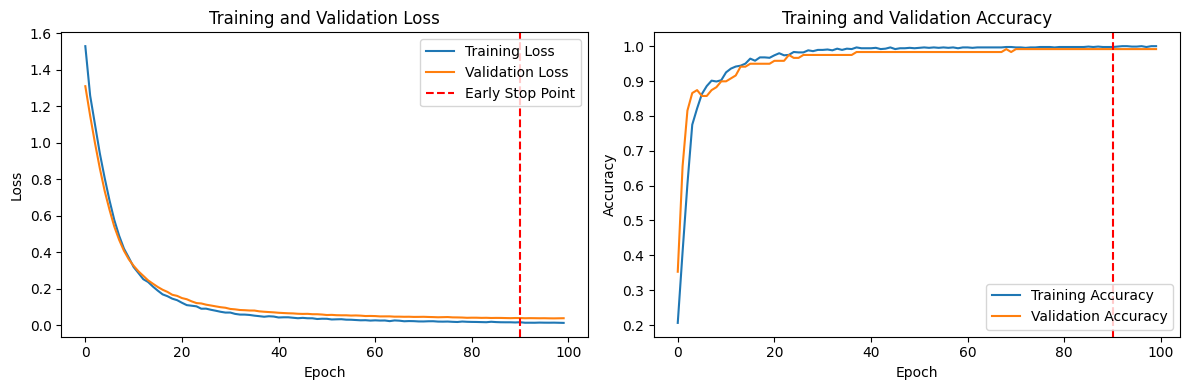

In [15]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. Standardization Code (Ensuring x_train, x_val are scaled) ---
# Calculate statistics ONLY on the training data
mean = x_train.mean(axis=(0, 1), keepdims=True)
std = x_train.std(axis=(0, 1), keepdims=True)

# Use a small epsilon to prevent division by zero for features with zero variance
epsilon = 1e-7

# Apply Standardization (Z-score normalization) to all data sets
x_train_scaled = (x_train - mean) / (std + epsilon)
x_val_scaled = (x_val - mean) / (std + epsilon)

# --- 2. Diagnostic Check ---
# The output should show values very close to 0 and 1
print("--- SCALING DIAGNOSTICS ---")
print(f"Mean of scaled x_train (across all data points): {x_train_scaled.mean():.4f}")
print(f"Std Dev of scaled x_train (across all data points): {x_train_scaled.std():.4f}")
print("---------------------------\n")

# Define the Early Stopping callback (CRITICAL)
# Stops training if the validation loss does not improve for 10 epochs (patience=10)
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

# Use the scaled data arrays and encoded labels from previous steps
# x_train_scaled, y_train_encoded, x_val_scaled, y_val_encoded
history = model.fit(
    x_train_scaled, 
    y_train_encoded, 
    epochs=100, 
    validation_data=(x_val_scaled, y_val_encoded),
    callbacks=[early_stopping], # Apply the callback
    verbose=2
)

def plot_training_history(history):
    """Plots the training and validation loss and accuracy history."""
    
    # Extract data from the history object
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    # Create the figure and subplots
    plt.figure(figsize=(12, 4))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.axvline(x=len(acc) - early_stopping.patience, color='r', linestyle='--', label='Early Stop Point')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.axvline(x=len(acc) - early_stopping.patience, color='r', linestyle='--')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

# Run the plot function after model.fit() completes
plot_training_history(history)

Evaluate

In [16]:
# --- 1. Final Data Preparation for Test Set ---

# Use the same epsilon as in the training standardization
epsilon = 1e-7 

# Scale the test features using the mean and std calculated ONLY from the training data
x_test_scaled = (x_test - mean) / (std + epsilon)

# One-Hot Encode the test labels
NUM_CLASSES = 4 # Use the correct number of classes (as used in y_train_encoded)
y_test_encoded = to_categorical(y_test, num_classes=NUM_CLASSES)

# --- 2. Evaluation and Prediction ---

# Evaluate the model
print("--- Model Evaluation ---")
# Use the scaled features and encoded labels
model.evaluate(x_test_scaled, y_test_encoded, verbose=2)

# Get predictions
pred_test = model.predict(x_test_scaled)

# Print confusion matrix
print("\n--- Confusion Matrix ---")
# Convert true and predicted one-hot vectors back to class indices for the matrix
print(tf.math.confusion_matrix(y_test_encoded.argmax(axis=1), pred_test.argmax(axis=1)))

--- Model Evaluation ---
8/8 - 0s - 8ms/step - categorical_accuracy: 0.9958 - loss: 0.0186
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

--- Confusion Matrix ---
tf.Tensor(
[[65  0  0  0]
 [ 0 54  0  0]
 [ 0  0 56  0]
 [ 0  1  0 63]], shape=(4, 4), dtype=int32)


Save model

In [17]:
import joblib
model.save('gesture_rec_model.h5')
joblib.dump(model, 'gesture_rec_model.pkl')
joblib.dump((mean, std), 'scaling_params.pkl')


['scaling_params.pkl']